# Проект "Определение стоимости автомобилей"

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Требуется  построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Основные шаги:
 - Изучим данные, заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные - удалим их.
 - Подготовим выборки для обучения моделей.
 - Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.
 - Проанализируем время обучения, время предсказания и качество моделей.
 - Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

Для оценки качества моделей применим метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.
Средствами библиотеки LightGBM построим модели градиентного бустинга.

Описание данных (данные находятся в файле autos.csv). 
Признаки:
 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - Repaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя
 - Price — цена (евро) - Целевой признак.

## Подготовка данных

### Общая информация о данных

In [1]:
#установим некоторые доп библиотеки
!pip install scikit-learn==1.1.3 -q
!pip install category_encoders -q
!pip install matplotlib==3.5.2 -q

In [2]:
#импортируем необходимые библиотеки,отключим предупреждения (в конце), 
#зададим формат вывода знаков после запятой

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import category_encoders as ce
import lightgbm as lgb
from time import time
from scipy import stats as st
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.preprocessing import OneHotEncoder

# загружаем классы для подготовки данных
from sklearn.preprocessing import  StandardScaler


# загружаем функцию для работы с метриками
from sklearn.metrics import mean_squared_error

# загружаем нужные модели
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Загрузим данные, выведем любые 10 строк для наглядной оценки данных, оценим общую информацию о данных

In [3]:
#загрузим данные из файла 
try:
    autos = pd.read_csv('/datasets/autos.csv', sep=',')
except:    
    autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', sep=',')
#выведем любые 10 строк
autos.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
89998,2016-03-13 22:37:20,5599,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,no,2016-03-13 00:00:00,0,29525,2016-04-06 19:18:01
211801,2016-04-02 19:55:16,1222,bus,2002,auto,116,alhambra,150000,11,gasoline,seat,no,2016-04-02 00:00:00,0,64625,2016-04-02 19:55:16
62893,2016-03-08 11:49:24,990,suv,1998,manual,124,NaN,20000,1,NaN,ford,no,2016-03-08 00:00:00,0,28876,2016-03-12 18:16:30
23476,2016-03-14 16:55:43,12500,wagon,2007,manual,197,5er,150000,7,gasoline,bmw,no,2016-03-14 00:00:00,0,54664,2016-04-05 23:16:25
63929,2016-03-31 15:52:39,4500,suv,1999,auto,220,grand,150000,7,lpg,jeep,yes,2016-03-31 00:00:00,0,26670,2016-03-31 15:52:39
164967,2016-04-03 18:42:53,550,small,2001,NaN,60,NaN,150000,12,petrol,peugeot,no,2016-04-03 00:00:00,0,66399,2016-04-05 18:46:33
329985,2016-03-18 05:36:25,250,NaN,2005,NaN,0,NaN,150000,0,petrol,volkswagen,NaN,2016-03-18 00:00:00,0,96132,2016-04-05 21:46:35
73560,2016-03-10 23:06:23,7500,convertible,2008,manual,125,tigra,90000,4,petrol,opel,no,2016-03-10 00:00:00,0,56294,2016-03-17 22:17:19
117276,2016-03-15 13:25:24,5800,sedan,2002,manual,231,3er,150000,5,petrol,bmw,no,2016-03-15 00:00:00,0,35578,2016-04-05 19:16:52
195530,2016-04-04 17:54:19,750,sedan,1993,manual,0,c_klasse,150000,0,NaN,mercedes_benz,yes,2016-04-04 00:00:00,0,81929,2016-04-06 19:48:28


Строковые признаки написаны со строчных букв, кол-во фотографий везде указано как 0(проверим всегда ли такое значение),дата скачивания и дата создания совпадают.

Выведем общую информацию о данных

In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные представлены 16 столбцами, как и заявлено. Тип данных представлен как строковыми, так и целочисленными данными(оценим корректность типа данных после удаления неинформативных столбцов, при этом бросается в глаза некорректный тип данных в столбцах, которые содержат даты - строковые). В ряде столбцов присутствуют пропуски.

Найдем кол-во явных дубликатов,оценим статистику по количественным признакам

In [5]:
f'Кол-во полных дубликатов:{autos.duplicated().sum()}'

'Кол-во полных дубликатов:4'

In [6]:
autos.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,"354,369.00","4,416.66","4,514.16",0.00,"1,050.00","2,700.00","6,400.00","20,000.00"
RegistrationYear,"354,369.00","2,004.23",90.23,"1,000.00","1,999.00","2,003.00","2,008.00","9,999.00"
Power,"354,369.00",110.09,189.85,0.00,69.00,105.00,143.00,"20,000.00"
Kilometer,"354,369.00","128,211.17","37,905.34","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"
RegistrationMonth,"354,369.00",5.71,3.73,0.00,3.00,6.00,9.00,12.00
NumberOfPictures,"354,369.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
PostalCode,"354,369.00","50,508.69","25,783.10","1,067.00","30,165.00","49,413.00","71,083.00","99,998.00"


 - Цена:значения колеблятся в интервале от 0 до 20000 евро, предложений с нулевой ценой не должно быть - требуется доп анализ,
 - Год регистрации: значения колеблятся в интервале от 1000 до 9999 - оба этих значения некорректные, год регистрации должен быть не позднее  даты создания анкет - требуется доп анализ,
 - Мощность: значение и интервале от 0 до 20000 лс, нулевого значения быть не должно,как и значения свыше максимально возможного на момент выгрузки базы  - требуется доп анализ,
 - Пробег: значения от 5000 до 150000,
 - Месяц регистрации: в интервале от 0 до 12, нулевого месяца не бывает - требуется доп анализ,
 - Кол-во фотографий: везде 0(далее не будем анализировать данный признак),
 - Почтовый индекс:в целом не является непрерывной переменной, более корректный тип - строковой, а не числовой.
 
Проверим на неявные дубликаты в категориальных признаках(кроме столбцов с данными о датах): 

In [7]:
#выведем уникальные значения
for column in autos.drop(['DateCrawled','DateCreated','LastSeen'],axis=1).select_dtypes(exclude='number'):
    print (column, ': ',   autos.select_dtypes(exclude='number')[column].unique())
    print(' ')

VehicleType :  [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
 
Gearbox :  ['manual' 'auto' nan]
 
Model :  ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'sp

 - Во всех столбцах, кроме бренда, есть пропуски в значениях. 
 - Неявные дубликаты при визуальном анализе выявлены:
   -  в столбце с моделью: 'range_rover' и 'rangerover',
   -  в столбце с типом топлива: 'petrol' и 'gasoline' - оба бензин,
 - Исходя из моделей,под названием бренда  'rover'  имеется ввиду 'range_rover'.

Оценим долю пропусков в каждом столбце

In [8]:
#создадим таблицу с долей пропусков по столбцам, значения зададим по убыванию
pd.DataFrame(round((autos.isna().sum()*100/len(autos)),2), columns=['доля пропусков,%'])\
.sort_values(by='доля пропусков,%', ascending=False).style.background_gradient('coolwarm')

,"доля пропусков,%"
Repaired,20.080000
VehicleType,10.580000
FuelType,9.280000
Gearbox,5.600000
Model,5.560000
DateCrawled,0.000000
Price,0.000000
RegistrationYear,0.000000
Power,0.000000
Kilometer,0.000000


Пропуски присутствуют в 5 столбцах, причем в столбце с информацией о ремонте машины больше всего(больше 20%). В остальных 4-х столбцах кол-во пропусков также существенное

### Предобработка данных

Определим неинформативные столбцы и удалим их,снова проверив на дубликаты, обработаем пропуски и аномалии.

Признаки, не связанные с ценообразованием и дублирующие:
 - кол-во фотографий и почтовый индекс никак не связаны с ценообразованием - удалим,
 - дата создания анкеты совпадает с датой скачивания анкеты - удалим столбец с датой скачивания,
 - нужность оставшихся столбцов с датами, месяцем регистрации оценим в процессе. 
 
Произведем замену 'range_rover' и 'rangerover', 'petrol' и 'gasoline', после чего снова проверим на полные дубликаты и удалим. 

In [9]:
#заменим 'rangerover' на 'range_rover' и снова проверим на полные дубликаты
autos['Model'] = autos['Model'].str.replace('rangerover','range_rover')
autos['FuelType'] = autos['FuelType'].str.replace('gasoline','petrol')
f'Кол-во полных дубликатов:{autos.duplicated().sum()}'

'Кол-во полных дубликатов:4'

Удалим явные дубликаты,удалим неинформативные столбцы, указанные выше.

In [10]:
#удлаим явные дубликаты
autos = autos.drop_duplicates()
#удалим дублирующие и неинформативные столбцы
autos = autos.drop(['DateCrawled','NumberOfPictures','PostalCode'],axis=1)

Еще раз и теперь визуально оценим распределение количественных признаков для оценки аномалий

In [11]:
#напишем функцию для вывода гистограммы и боксплота по каждому признаку 
def hist_box(data,column):
    fig, ax = plt.subplots(figsize = (20, 5));
    
    ax = plt.subplot(1, 2, 1);
    data.plot(kind='hist',y=column,histtype='step',bins=50,\
                                 linewidth=5,alpha=0.7,ax=ax);
    plt.ylabel('Кол-во авто', fontsize=12);
    plt.xlabel(column, fontsize=12);
    plt.title('Гистограмма распределения');

    data.boxplot(column, ax = plt.subplot(1, 2, 2));
    plt.ylabel('Значение по признаку '+column, fontsize=12);
    plt.title('Диаграмма размаха');

    fig.suptitle('Распределение значений по признаку '+column,fontsize=14);
    plt.subplots_adjust(wspace=1,hspace = 1);
    plt.show();

<Figure size 432x288 with 0 Axes>

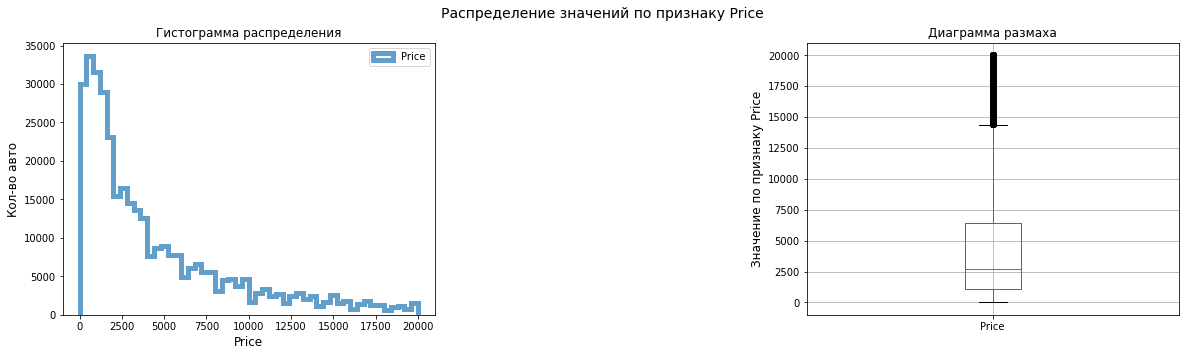

<Figure size 432x288 with 0 Axes>

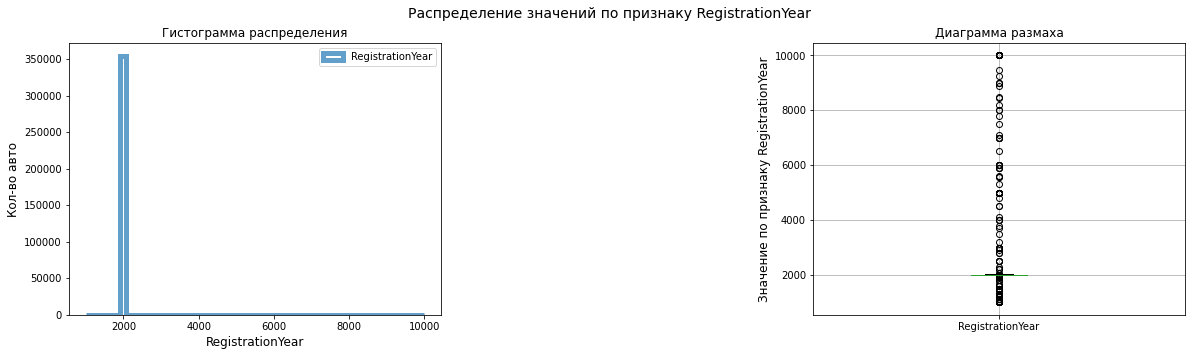

<Figure size 432x288 with 0 Axes>

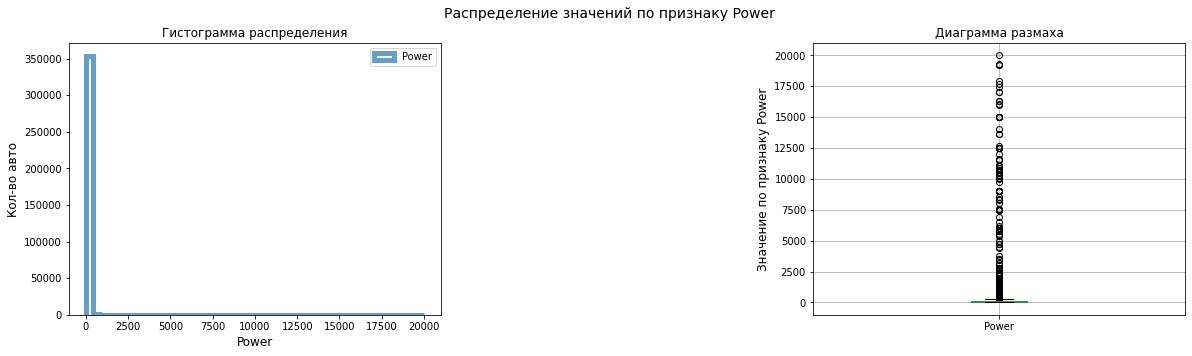

<Figure size 432x288 with 0 Axes>

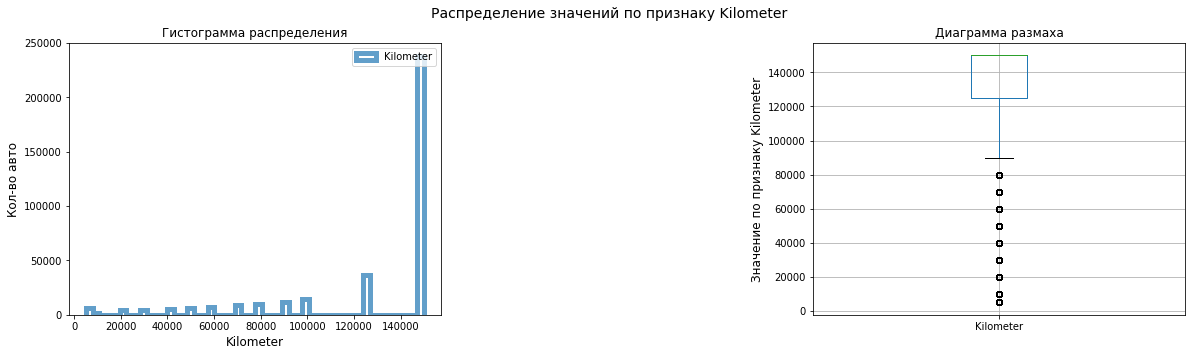

<Figure size 432x288 with 0 Axes>

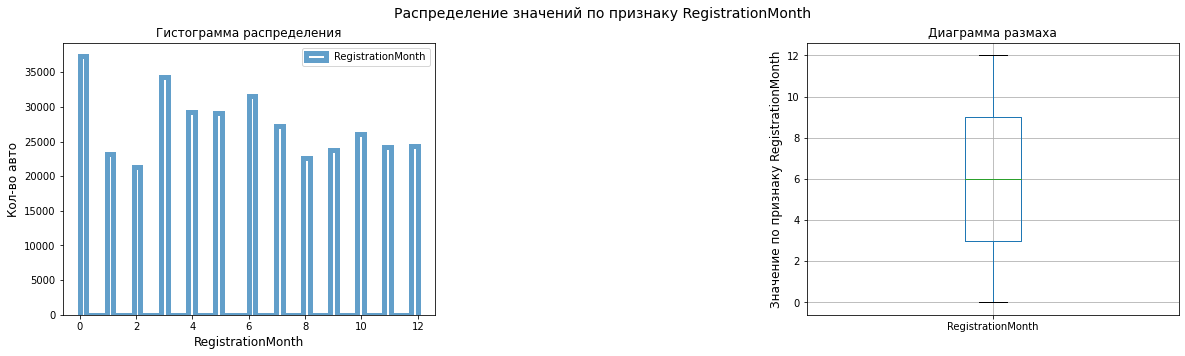

In [12]:
#выведем  диаграммы распределения для каждого числового признака
for i in  autos.select_dtypes(include='number').columns.tolist():
    plt.subplots_adjust(hspace = 1.5);
    hist_box(autos, i);

 - Цена:цена в размере 0 евро некорректна (возможно продавец либо забыл указать цену, либо цена договорная), в любом случае это приведет к неверной работе модели, также есть значения, близкие к 0(возможно владельцы указали цену в тыс евро - проверить не представляется возможным), поэтому такие значение тоже стоит исключить - проведем оценку до 5%-ному и 95%-ному квантилям
 - Год регистрации: первые машиины появились в конце 19 века (все ранее этого и позднее 2023/либо даты создания анкеты - аномалии),машины конца 19 века - первой половины 20 века являются скорее раритетом, а это уже выбросы, т.к. ценообразование по ним работает совершенно по-другому, поэтому все значения менее хотя бы 1960 года стоит исключить -перед исключем проверим, насколько много таких авто. Исключением по верхней планке будет являться либо 2023 либо год размещения объявления, т.к. год регистрации позднее этой даты не может быть.Удалим все свыше верхней планки и снова оценим распределение
 - Мощность: на текущий день (немного забегая вперед, мы выявили, что это 2016 год) самая высокая мощность у автомобиля составляет 1500 лс, а никак не 2500 и выше (при заполнении продавцом видимо была допущена ошибка),топ самых мощных авто начинается от 600 лс. Авто с мощностью свыше 600 являются премиальными, вероятность их продажи через базу минимальна, скорее всего при заполнении данных закралась ошибка.Нулевой мощности тоже не бывает. Т.о., по авто с мощностью свыше 600 и 0 заменим на медианное значение мощности авто аналогичной модели.
 - Пробег:отклоняющихся значений не выявлено.
 - Месяц регистрации: значение скорее имеет год регистрации, данные по месяцу регистрации распределены нормально, в нашей выборке кол-во автомобилей по месяцам в целом распределено равномерно - считаю необходимым исключить данный признак из дальнейшего анализа, т.к. он не информативен для модели.
 
 
Удалим столбец с месяцем регистрации.Проведем анализ цен по 5%-ному и 95%-ному квантилям

In [13]:
autos = autos.drop(['RegistrationMonth'],axis=1)
autos['Price'].quantile([.05, 0.95])

0.05      200.00
0.95   14,600.00
Name: Price, dtype: float64

Удалим все значения цены, ниже 200 евро.На боксплоте выше видим, что как раз примерно на 95%-ном квантиле остальное оценивается как выбросы: поскольку признак цены является целевым, после всей проведенной предобратоки вернемся к ее распределению и решим какие значения оставим.

Год регистрации: удалим нереалистичные года и оценим распределение даных по годам 

In [14]:
#удалим данные по цене ниже 200 евро
autos = autos.query('Price>200')
#переведем формат данных с датами из числового в формат даты
autos[['DateCreated','LastSeen']] = autos[['DateCreated','LastSeen']].apply(pd.to_datetime)
#вытащим максимальный год из даты создания анкет
year = autos['DateCreated'].dt.year.max()
year

2016

Максимальный год создания анкет - 2016, соответственно никаких авто с регистрацией позднее этого года быть не должно, как и ранее 1900. Оценим распределение данных по этим годам

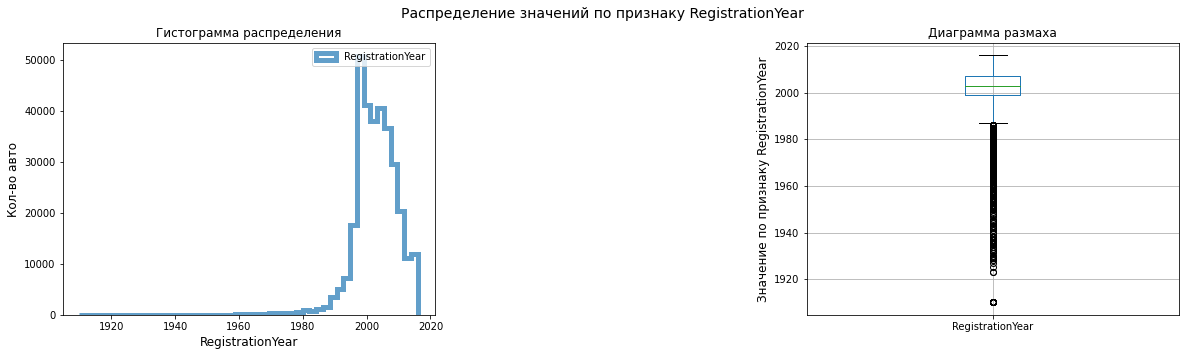

In [15]:
hist_box(autos.query('1900<RegistrationYear<=2016'),'RegistrationYear')

Авто до 1960 года мало, это скорее выбросы(раритет), удалим такие авто.

In [16]:
#сохраним только данные с авто по годам регистрации не позднее максимальной даты анкет и не ранее 1960
autos = autos.query('1960<RegistrationYear<=@year')
autos['RegistrationYear'].describe()

count   320,944.00
mean      2,002.76
std           6.58
min       1,961.00
25%       1,999.00
50%       2,003.00
75%       2,007.00
max       2,016.00
Name: RegistrationYear, dtype: float64

Дата создания объявления больше не нужна, как и дата последней активности пользователя- удалим.

In [17]:
autos = autos.drop(['LastSeen','DateCreated'],axis=1)

Оценим распределение данных по годам

Оценим по авто с мощностью свыше 600 лс, что скорее всего является ошибкой при заполнении, заменим значение мощности на медианное значение мощности по данной модели авто. Также авто с мощностью ниже 20 лс являются либо аномалиями, либо очень редким явлением  и наличие таких значений будут искажать работу модели - удалим их

In [18]:
#переведем аномалии с мощностью в пропуски и далее заполним эти пропуски медианным значение по модели
autos.loc[(autos['Power'] > 600)|(autos['Power']==0), 'Power'] = None
autos['Power'] = autos['Power'].fillna(autos.groupby('Model')['Power'].transform('median'))
autos = autos.query('Power>20')
autos['Power'].describe()

count   316,870.00
mean        120.46
std          52.82
min          21.00
25%          79.00
50%         113.00
75%         150.00
max         600.00
Name: Power, dtype: float64

Оценим есть ли аномалии по максимальным значениям цены

In [19]:
autos.sort_values(by='Price',ascending=False).head(15)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
342303,20000,sedan,2013,manual,194.00,insignia,60000,petrol,opel,no
110872,20000,suv,2010,manual,163.00,amarok,80000,petrol,volkswagen,no
13681,20000,suv,2009,auto,224.00,g_klasse,150000,petrol,mercedes_benz,no
1515,20000,sedan,2010,auto,239.00,a6,150000,petrol,audi,no
113554,20000,wagon,2014,manual,124.00,auris,30000,petrol,toyota,no
197617,20000,coupe,2010,auto,170.00,3er,90000,petrol,bmw,no
100694,20000,sedan,2010,auto,184.00,5er,150000,petrol,bmw,no
19551,20000,convertible,2013,manual,105.00,beetle,30000,petrol,volkswagen,no
227601,20000,convertible,1972,auto,176.00,NaN,150000,petrol,sonstige_autos,NaN
13360,20000,coupe,2004,manual,325.00,crossfire,125000,petrol,chrysler,no


Как видим в топ-15 по цене входят такие бренды как audi, mercedes_benz, поэтому в целом оценить какие значения являются некорректными не представляется возможным.

In [20]:
autos.sort_values(by='Power',ascending=False).head(15)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
154600,16500,sedan,2003,auto,600.00,NaN,150000,petrol,mercedes_benz,no
146339,12500,sedan,2002,auto,600.00,s_type,150000,NaN,jaguar,no
43600,12999,wagon,2004,auto,600.00,a6,150000,petrol,audi,NaN
186427,16500,coupe,2000,manual,600.00,other,5000,petrol,toyota,no
102613,19500,coupe,1974,auto,600.00,other,5000,petrol,chevrolet,no
13373,18500,small,2002,auto,600.00,s_type,150000,NaN,jaguar,no
162460,12000,sedan,2002,auto,600.00,s_type,150000,petrol,jaguar,no
243042,15900,sedan,2003,auto,600.00,s_klasse,150000,petrol,mercedes_benz,no
151744,12500,wagon,2004,auto,600.00,a6,150000,petrol,audi,NaN
138257,14750,sedan,2014,auto,585.00,e_klasse,150000,petrol,mercedes_benz,no


Входящие в топ-15 по мощности авто вполне могут иметь таковую.

Оценим распределение признаков после проведенной обработки

<Figure size 432x288 with 0 Axes>

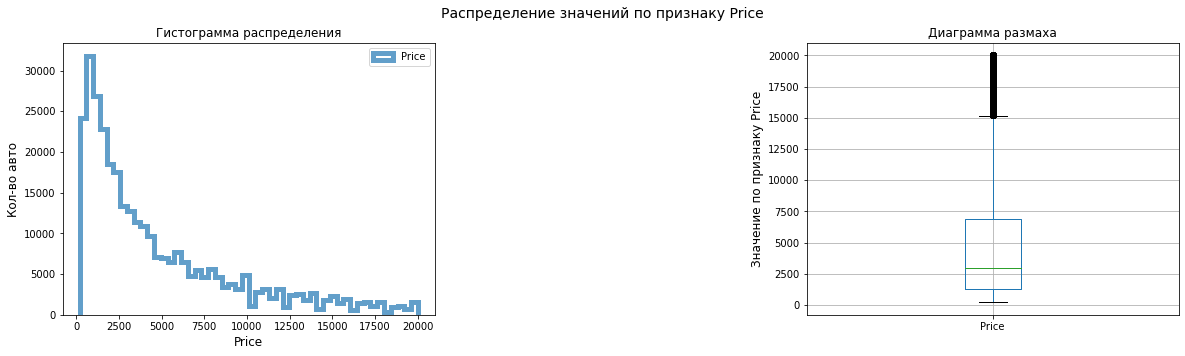

<Figure size 432x288 with 0 Axes>

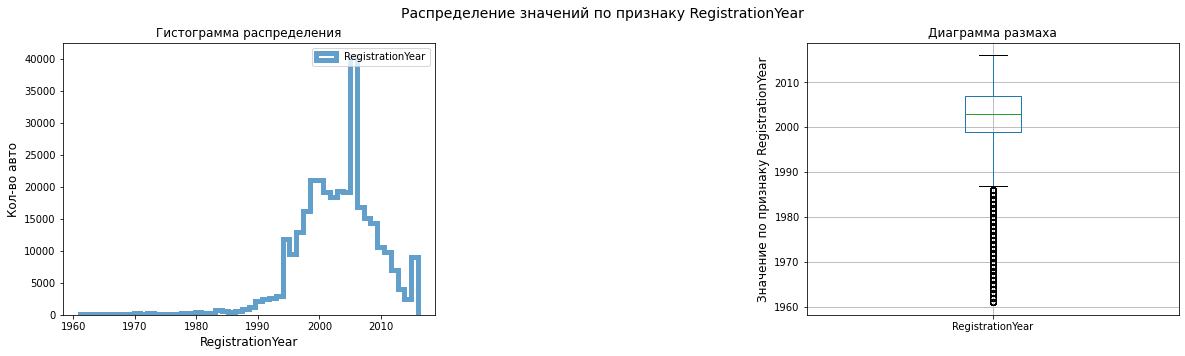

<Figure size 432x288 with 0 Axes>

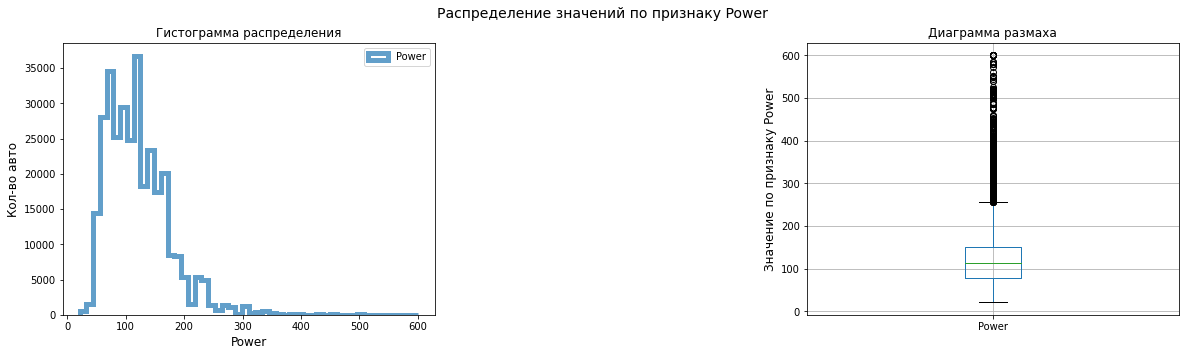

<Figure size 432x288 with 0 Axes>

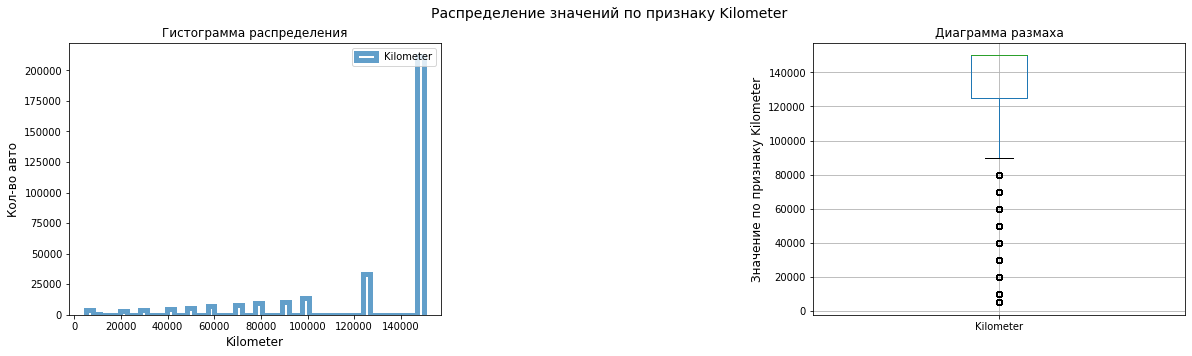

In [21]:
#выведем  диаграммы 
for i in  autos.select_dtypes(include='number').columns.tolist():
    plt.subplots_adjust(hspace = 1.5);
    hist_box(autos, i);

- Распределение цены согласно боксплоту имеет выбросы, но они не оцениваются как аномалии - оставим в текущем виде,
- Год регистрации: в целом значение находятся в интервале от 1987 до 2016, до этого присутствует несколько значений,
- Мощность: значение свыше 250 лс согласно боксплота оцениваются как выбросы, но их немного и они в целом имеют место быть как мы оценили выше,
- Пробег: значение преимущественно находятся в интервале от 90000 до 146000 км, есть некоторые значения меньше этого интервала, но они могут иметь место.

Повторно проверим долю пропусков

In [22]:
#создадим таблицу с долей пропусков по столбцам, значения зададим по убыванию
pd.DataFrame(round((autos.isna().sum()*100/len(autos)),2), columns=['доля пропусков,%'])\
.sort_values(by='доля пропусков,%', ascending=False).style.background_gradient('coolwarm')

,"доля пропусков,%"
Repaired,16.770000
FuelType,6.220000
VehicleType,4.910000
Gearbox,3.770000
Model,3.300000
Price,0.000000
RegistrationYear,0.000000
Power,0.000000
Kilometer,0.000000
Brand,0.000000


В связи с удалением некоторых данных  кол-во пропусков немного сократилось, стратегия по обработке оставшихся пропусков следующая:
- модель: важнейший фактор при ценообразовании, не можем наполнить, например, наиболее частыми значениями по бренду, - удалим пропуски,
- тип коробки передач,тип кузова,тип топлива: для каждой модели может быть несколько модификаций по данным параметрам, поэтому заполнить данные пропуски (например, наиболее частыми значениями по модели), не искажая данные, невозможно. Поэтому наполним данные пропуски значением - 'unknown'
- было ли авто в ремонте: самое большое кол-во пропусков, также наполним - 'unknown'

In [23]:
#удалим строки с пропусками в модели
autos = autos.dropna(subset=['Model'])
#заполним пропуски в столбце с данными по ремонту
autos[['Repaired','VehicleType','FuelType','Gearbox']] = autos[['Repaired','VehicleType','FuelType','Gearbox']].fillna('unknown')
#выведем кол-во оставшихся после этого строк
len(autos)

306398

In [24]:
#создадим таблицу с долей пропусков по столбцам, значения зададим по убыванию
pd.DataFrame(round((autos.isna().sum()*100/len(autos)),2), columns=['доля пропусков,%'])\
.sort_values(by='доля пропусков,%', ascending=False).style.background_gradient('coolwarm')

,"доля пропусков,%"
Price,0.000000
VehicleType,0.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
FuelType,0.000000
Brand,0.000000
Repaired,0.000000


Пропуски обработы, оценим на полные дубликаты

In [25]:
f'Кол-во полных дубликатов:{autos.duplicated().sum()}'

'Кол-во полных дубликатов:42940'

После удаления неиформативных столбцов, корректировки аномалий и наполнения пропусков, появилось большое кол-во дубликатов - удалим их

In [26]:
#удалим явные дубликаты
autos = autos.drop_duplicates()
autos.shape

(263458, 10)

Итого после удаления аномальных значений, заполнения пропусков осталось 263,4 тыс строк 10 столбцов.

### Подготовка выборок для обучения моделей

Подготовим выборки для обучения моделей не бустинга, т.к. для GBM не нужно отдельно обрабатывать категориальные признаки, она это делает сама, туда лучше подавать необработанные данные.
Выделим целевой и входные признаки, закодируем признаки модель и прочие с более, чем 2-мя возможными значениями через кодировщик TargetEncoder, затем масштабируем все признаки (сделаем сначала для тренининговой, затем для тестовой).

In [27]:
#выделим целевой признак и прочие, разобьем выборку на тестовую и тренинговую
y = autos['Price']
X = autos.drop(['Price'], axis=1)


X_train,X_test,y_train,y_test = train_test_split( 
                                     X,
                                     y,
                                     test_size = 0.25,
                                     random_state = 12345
    )
X_train.head(1)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
157428,small,2005,manual,75.00,ibiza,125000,petrol,seat,no


In [28]:
#закодируем признаки со строковым типом и более чем 2-мя возможными значениями
target_encoder = ce.TargetEncoder(cols=['VehicleType','Model','FuelType','Brand','Repaired'])
X_train = target_encoder.fit_transform(X_train,y_train)
#закодириуем бинарный признак "коробка передач"
X_train['Gearbox'] = X_train['Gearbox'].apply(lambda x: 1 if x=='auto' else 0)
#выведем любые 10 строк получившегося после кодировки
X_train.sample(10)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
265268,"5,160.30",2000,1,140.00,"4,091.66",150000,"5,043.13","4,456.38","5,652.35"
304285,"5,056.46",2005,1,218.00,"12,232.07",150000,"5,043.13","6,712.96","5,652.35"
151452,"5,160.30",2012,0,103.00,"2,428.36",60000,"5,043.13","2,603.02","3,126.38"
45315,"5,160.30",2006,0,101.00,"4,725.58",150000,"5,043.13","5,023.60","5,652.35"
95607,"5,160.30",2006,0,90.00,"2,794.82",125000,"5,043.13","3,175.94","5,652.35"
271698,"5,160.30",1997,0,75.00,"3,359.79",125000,"5,043.13","3,175.94","3,126.38"
83430,"5,056.46",1998,0,82.00,"3,359.79",150000,"5,043.13","3,175.94","5,652.35"
190888,"5,160.30",1998,1,165.00,"6,610.88",150000,"4,069.70","6,770.64","2,276.33"
19040,"6,345.36",2008,0,192.00,"10,032.08",150000,"5,043.13","9,311.56","2,276.33"
157704,"5,623.66",1996,0,174.00,"5,293.91",150000,"5,043.13","5,023.60","5,652.35"


In [29]:
#масштабируем входные признаки
scaler = StandardScaler()
columns = X_train.columns
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = columns)

X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,-1.23,0.31,-0.50,-0.88,-0.40,-0.06,0.27,-0.34,0.60
1,0.11,-0.76,1.99,2.86,-0.09,0.61,0.27,-0.29,0.60
2,-1.23,1.39,1.99,-0.07,-0.09,-2.59,5.99,-1.51,0.60
3,0.18,-5.81,1.99,-0.07,-0.09,-0.73,0.27,0.86,-2.05
4,0.11,0.47,-0.50,0.92,0.66,0.61,0.27,-0.34,-2.05


In [30]:
#проведем кодирование тестовой выборки
X_test = target_encoder.transform(X_test,y_test)
X_test['Gearbox'] = X_test['Gearbox'].apply(lambda x: 1 if x=='auto' else 0)
X_test = pd.DataFrame(scaler.transform(X_test), columns = columns)

X_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,0.11,0.31,-0.50,0.54,0.20,0.61,0.27,1.20,0.60
1,0.49,0.31,-0.50,-0.10,-0.51,0.61,0.27,-0.88,0.60
2,-1.23,-0.60,-0.50,-0.39,-0.63,0.61,0.27,-1.13,0.60
3,-1.58,2.00,1.99,0.54,0.40,0.61,-3.65,0.86,-1.38
4,0.11,1.39,1.99,0.66,1.91,-2.59,0.27,0.86,-1.38



**Вывод по предобработке данных**:

 - Входные данные были представлены 16 столбцами и 354369 строками.
 - Отобраны признаки, необходимые для построения моделей.
 - Типы данных соответствуют описанию,
 - Пропущенные значения, выбросы, а также неправдоподобные значения в признаках по возможности заполнены на основе имеющейся информации. Остальные объекты удалены - после чего осталось 10 столбцов и 306633 строк.
 - После удаления неинформативных столбцов, обработки пропусков и аномалий появилось существенное кол-во полных дубликатов, после удаления которых осталось 263458 строк или 74% строк от исходных данных.
 - Данные разделены на тестовую и обучающую выборки в соотношении 1:4, признаки закодированы и масштабированы. 

## Обучение моделей

Рассмотрим несколько линейных моделей (с регуляризацией и без), дерево решений и модель бустинга. Подберем для каждой модели  такие гиперпараметры, при которых метрика MSE, а соответственно RMSE будет меньше.

### Линейная регрессия

In [31]:
# инициализируем модель
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
#зададим гиперпараметры для перебора
parameters = {
    'fit_intercept':[True,False],
    'normalize':[True,False], 
    'copy_X':[True, False]
}
#произведем поиск лучше модели рандомайзером
random_lr = RandomizedSearchCV(
    model_lr,
    parameters,
    cv=5,
    n_jobs=-1,
    scoring = 'neg_mean_squared_error'
)
#обучим лучшую модель
random_lr.fit(X_train, y_train)
# выведем параметры лучшей модели
print('Параметры лучшей линейной модели: ' , random_lr.best_params_)

Параметры лучшей линейной модели:  {'normalize': True, 'fit_intercept': True, 'copy_X': True}


### Линейная модель с L1 регуляризацией

In [32]:
# инициализируем модель
model_lasso = Lasso(random_state=12345)
model_lasso.fit(X_train, y_train)
#зададим гиперпараметры для перебора
parameters = {
    'alpha':range(1,20)
}
#произведем поиск лучше модели рандомайзером и обучим ее
random_lasso = RandomizedSearchCV(
    model_lasso,
    parameters,
    cv=5,
    n_jobs=-1,
    scoring = 'neg_mean_squared_error'
)
#обучим лучшую модель
random_lasso.fit(X_train, y_train)
# выведем параметры лучшей модели
print('Параметры лучшей линейной модели с L1 регуляризацией: ', random_lasso.best_params_)


Параметры лучшей линейной модели с L1 регуляризацией:  {'alpha': 1}


### Линейная модель с L2 регуляризацией

In [33]:
# инициализируем модель
model_ridge = Ridge(random_state=12345)
model_ridge.fit(X_train, y_train)
#зададим гиперпараметры для перебора
parameters = {
    'alpha':range(1,20)
}
#произведем поиск лучше модели рандомайзером и обучим ее
random_ridge = RandomizedSearchCV(
    model_ridge,
    parameters,
    cv=5,
    n_jobs=-1,
    scoring = 'neg_mean_squared_error'
)
random_ridge.fit(X_train, y_train)
# выведем параметры лучшей модели 
print('Параметры лучшей линейной модели с L2 регуляризацией: ', random_ridge.best_params_)

Параметры лучшей линейной модели с L2 регуляризацией:  {'alpha': 19}


### Модель дерева решений

In [34]:
# инициализируем модель
model_dtr = DecisionTreeRegressor(random_state=12345)
model_dtr.fit(X_train, y_train)
#зададим гиперпараметры для перебора
parameters = {
      'max_depth': [3, 5, 7, 9],
    'min_samples_split': range(2, 10),
        'min_samples_leaf': range(2, 10)
}
#произведем поиск лучше модели рандомайзером и обучим ее
random_dtr = RandomizedSearchCV(
    model_dtr,
    parameters,
    cv=5,
    n_jobs=-1,
    scoring = 'neg_mean_squared_error'
)
random_dtr.fit(X_train, y_train)
# выведем параметры лучшей модели
print('Парамтеры лучшей модели Дерева решений: ', random_dtr.best_params_)

Парамтеры лучшей модели Дерева решений:  {'min_samples_split': 9, 'min_samples_leaf': 6, 'max_depth': 9}


Перейдем к бустингу

### Модель LGBMRegressor 

Повторно подготовим выборки для обучения модели, т.к. для GBM не нужно отдельно обрабатывать категориальные признаки, она это делает сама.

In [35]:
#выделим целевой признак и прочие
y_boost = autos['Price']
X_boost = autos.drop(['Price'], axis=1)

#выделим категориальные/количественные признаки, 
numerical_features = X_boost.select_dtypes(include='number').columns
categorical_features = X_boost.select_dtypes(exclude='number').columns

#переведем категориальные признаки в тип category, который требуется для LightGBM
X_boost[categorical_features] = X_boost[categorical_features].astype('category')

#сплит
X_boost_train,X_boost_test,y_boost_train,y_boost_test = train_test_split( 
                                     X_boost,
                                     y_boost,
                                     test_size = 0.25,
                                     random_state = 12345
    )

In [36]:
# инициализируем модель
model_lgb = lgb.LGBMRegressor(random_state=12345)
model_lgb.fit(X_boost_train, y_boost_train)
#зададим гиперпараметры для перебора
parameters = {
      'learning_rate': [0.3, 0.7],
              'max_depth': [3, 6, 9]
}
#произведем поиск лучше модели рандомайзером и обучим ее
random_lgb = RandomizedSearchCV(
    model_lgb,
    parameters,
    cv=5,
    n_jobs=-1,
    scoring = 'neg_mean_squared_error'
)
random_lgb.fit(X_boost_train, y_boost_train)
# выведем параметры лучшей модели
print('Параметры лучшей модели бустинга: ', random_lgb.best_params_)

Параметры лучшей модели бустинга:  {'max_depth': 9, 'learning_rate': 0.3}


**Вывод по обучению моделей**:
 - Было обучено 3 линейных модели, дерево решений и модель бустинга LGBMRegressor.
 
Далее оценим метрику RMSE при кросс-валидации для каждой из моделей

## Анализ моделей

Проанализируем время обучения, предсказания и качество каждой  модели.
После чего, опираясь на критерии заказчика, выберем из них необходимую  модель.

### Линейная регрессия

In [37]:
# найдем время обучения модели
start = time()

model_lr = random_lr.best_estimator_ 

model_lr.fit(X_train, y_train)

end = time()
lr_training_time =pd.Series(end-start)

#построим предсказания на тренинге для нахождения скорости предсказания
start = time()

predictions_lr = model_lr.predict(X_train)

end = time()
lr_preds_time = pd.Series(end-start)

#посчитаем метрику RMSE лучшей модели при кросс-валидации
rmse_lr = pd.Series(round(abs(random_lr.best_score_) ** 0.5))

# объединим все в одну таблицу
lr = pd.DataFrame(zip(rmse_lr,lr_training_time,lr_preds_time), \
                  columns = ['rmse_cv','training_time(sec)','preds_time(sec)'])
lr

,rmse_cv,training_time(sec),preds_time(sec)
0,2834,0.21,0.08


### Линейная модель с L1 регуляризацией

In [38]:
# найдем время обучения модели
start = time()

model_lasso = random_lasso.best_estimator_ 
model_lasso.fit(X_train, y_train)

end = time()
lasso_training_time =pd.Series(end-start)

#построим предсказания на тренинге для нахождения скорости предсказания
start = time()

predictions_lasso = model_lasso.predict(X_train)

end = time()
lasso_preds_time = pd.Series(end-start)

#посчитаем метрику RMSE лучшей модели при кросс-валидации
rmse_lasso = pd.Series(round(abs(random_lasso.best_score_) ** 0.5))

# объединим все в одну таблицу
lasso = pd.DataFrame(zip(rmse_lasso,lasso_training_time,lasso_preds_time),\
                     columns = ['rmse_cv','training_time(sec)','preds_time(sec)'])
lasso

,rmse_cv,training_time(sec),preds_time(sec)
0,2834,0.39,0.10


### Линейная модель с L2 регуляризацией

In [39]:
# найдем время обучения модели
start = time()

model_ridge = random_ridge.best_estimator_ 
model_ridge.fit(X_train, y_train)

end = time()
ridge_training_time =pd.Series(end-start)

#построим предсказания на тренинге для нахождения скорости предсказания
start = time()

predictions_ridge = model_ridge.predict(X_train)

end = time()
ridge_preds_time = pd.Series(end-start)

#посчитаем метрику RMSE лучшей модели при кросс-валидации
rmse_ridge = pd.Series(round(abs(random_ridge.best_score_) ** 0.5))

# объединим все в одну таблицу
ridge = pd.DataFrame(zip(rmse_ridge,ridge_training_time,ridge_preds_time), \
                     columns = ['rmse_cv','training_time(sec)','preds_time(sec)'])
ridge

,rmse_cv,training_time(sec),preds_time(sec)
0,2834,0.02,0.00


### Модель дерева решений

In [40]:
# найдем время обучения модели
start = time()

model_dtr = random_dtr.best_estimator_ 
model_dtr.fit(X_train, y_train)

end = time()
dtr_training_time =pd.Series(end-start)

#построим предсказания на тренинге для нахождения скорости предсказания
start = time()

predictions_dtr = model_dtr.predict(X_train)

end = time()
dtr_preds_time = pd.Series(end-start)

#посчитаем метрику RMSE лучшей модели при кросс-валидации
rmse_dtr = pd.Series(round(abs(random_dtr.best_score_) ** 0.5))

# объединим все в одну таблицу
dtr = pd.DataFrame(zip(rmse_dtr,dtr_training_time,dtr_preds_time), \
                   columns = ['rmse_cv','training_time(sec)','preds_time(sec)'])
dtr

,rmse_cv,training_time(sec),preds_time(sec)
0,1983,0.47,0.02


### Модель LGBMRegressor 

In [41]:
# найдем время обучения модели
start = time()

model_lgb = random_lgb.best_estimator_ 
model_lgb.fit(X_boost_train, y_boost_train)

end = time()
lgb_training_time =pd.Series(end-start)

#построим предсказания на тренинге для нахождения скорости предсказания
start = time()

predictions_lgb = model_lgb.predict(X_boost_train)

end = time()
lgb_preds_time = pd.Series(end-start)

#посчитаем метрику RMSE лучшей модели при кросс-валидации
rmse_lgb = pd.Series(round(abs(random_lgb.best_score_) ** 0.5))

# объединим все в одну таблицу
lgb = pd.DataFrame(zip(rmse_lgb,lgb_training_time,lgb_preds_time),\
                   columns = ['rmse_cv','training_time(sec)','preds_time(sec)'])
lgb

,rmse_cv,training_time(sec),preds_time(sec)
0,1621,9.50,1.50


### Вывод по анализу моделей

In [42]:
#выведем сводную таблицу с критериями по всем моделям, отсортируем по метрике RMSE

models = pd.concat([lr,lasso,ridge,dtr,lgb],sort=False,axis=0)
models['rmse_acceptable'] = models['rmse_cv'].apply(lambda x: 'no!' if x>=2500 else 'yes')
models.sort_values(by='rmse_cv')

,rmse_cv,training_time(sec),preds_time(sec),rmse_acceptable
0,1621,9.50,1.50,yes
0,1983,0.47,0.02,yes
0,2834,0.21,0.08,no!
0,2834,0.39,0.10,no!
0,2834,0.02,0.00,no!


 - При проведении кросс-валидации лучшее значение метрики RMSE показала модель бустинга LGBMRegressor:RMSE=1621. Также достаточную метрику показала модель дерева решений: RMSE=1983
 - Линейные модели не подходят по значению метрики: RMSE=2834 - их отсекаем и далее не анализируем.
 - По времени обучения у выбранных моделей, наоборот, аутсайдером является модель бустинга: время обучения дерева решений составляет милисекунды, в то время как у бустинга более 9 секунд.

Т.о., необходимо решить будем ли мы пользоваться бустингом с самой лучшей метрикой качества, но долгим по сравнению с деревом решений временем обучения и предсказания, либо выберем более быструю модель дерево решения с менее точной,но тем не менее приемлемой метрикой качества модели.

Метрика RMSE бустинга точнее по отношению к дереву решения на 17%, что является достаточно существенным. При этом время обучения отличается в десятки раз, что при большом кол-ве данных может также быть критичным. Несмотря, на казалось бы большую разницу во времени обучения и предсказания, стоит отметить, что обучатся модель будет не постоянно, время предсказания не является настолько уже критично большим - оно выглядит таким на фоне выбранных моделей.

Поэтому, по совокупности фактов: если в большей степени важна точность модели - лучше выбрать модель бустинга LGBMRegressor, если    на вход будет подаваться очень  большой объем данных (в разы больше объемов нашей выборки) и при этом критично важно сократить затрачиваемое моделью время на получение результата - то лучше воспользоваться моделью дерева решений.

Посчитаем метрику обоих моделей на тестовой выборке

In [43]:
pred_lgb = random_lgb.best_estimator_.predict(X_boost_test)
pred_dtr = random_dtr.best_estimator_.predict(X_test)

print('RMSE для  модели бустинга на тесте : ',round(mean_squared_error(y_boost_test,pred_lgb) ** 0.5,))
print('RMSE для дерева решений на тесте : ',round(mean_squared_error(y_test,pred_dtr) ** 0.5,))

RMSE для  модели бустинга на тесте :  1618
RMSE для дерева решений на тесте :  1968


Видим, что и на тестовой выборке модель бустинга показала лучшее значение метрики. Моделью дерева решений стоит пользоваться только в случае, если крайне важным явлется сокращение затрачиваемого моделью времени на обучение/предсказание.

## Вывод

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. В связи с этим в рамках проекта было построено несколько моделей для определения стоимости, после чего данные модели оценивались по следующим критерям заказчика:
 - качество предсказания(значение метрики RMSE должно быть меньше 2500);
 - скорость предсказания;
 - время обучения.

Перед построением моделей проведена предобработка данных:
   - Входные данные были представлены 16 столбцами и 354369 строками.
   - Отобраны признаки, необходимые для построения моделей.
   - Типы данных соответствуют описанию,
   - Пропущенные значения, выбросы, а также неправдоподобные значения в признаках по возможности заполнены на основе имеющейся информации. Остальные объекты удалены - после чего осталось 10 столбцов и 306633 строк.
   - После удаления неинформативных столбцов, обработки пропусков и аномалий появилось существенное кол-во полных дубликатов, после удаления которых осталось 263458 строк или 74% строк от исходных данных.
   - Данные разделены на тестовую и обучающую выборки в соотношении 1:4, признаки закодированы и масштабированы.

Обучено 3 линейных модели, дерево решений и модель бустинга LGBMRegressor.
   - для каждой из моделей подбирались разные гиперпараметры, для которых метрика MSE, а соответственно RMSE, покажет наилучший результат. 

Далее проведен анализ по критериям заказчика:
 - наихудшую метрику при кросс-валидации показали линейные модели (RMSE - 2834), приемлемую - дерево решений(RMSE - 1983), самую лучшую - бустинг (значение метрики 1621).
 - Линейные модели не подходят по значению метрики: RMSE=2834,
 - По времени обучения у выбранных моделей, наоборот, аутсайдером является модель бустинга: время обучения дерева решений составляет милисекунды, в то время как у бустинга более 9 секунд.

Метрика RMSE бустинга точнее по отношению к дереву решения на 17%, что является достаточно существенным. При этом время обучения отличается в десятки раз, что при большом кол-ве данных может также быть критичным. Несмотря, на казалось бы большую разницу во времени обучения и предсказания, стоит отметить, что обучатся модель будет не постоянно, время предсказания не является настолько уже критично большим - оно выглядит таким на фоне выбранных моделей.

Поэтому, по совокупности фактов,исходя из требований заказчика для определения рыночной стоимости авто рекомендуем: 
 - если **в большей степени важна точность модели** - использовать разработанную **модель бустинга LGBMRegressor**, 
 - если  **на вход будет подаваться очень  большой объем данных (в десятки разы больше объемов нашей выборки) и при этом принципиально сократить время, затрачиваемое моделью,** - то лучше воспользоваться **моделью дерева решений**.